# Pipelines

Ich code hier all meine Modelle im default und packe sie danach in einen Stacker. Dann vergleiche ich die Ergebnisse. 
Ggf. muss ich danach noch Parametertuning betreiben, wenn ich nur Schrott heraus bekomme. 

**Modelle:**

1. Lineare Regression
2. Elastic Net Regression
3. k-Nearest-Neighbors Regression
4. Random Forest Regression
5. Support Vector Regression
6. Stacker

C:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


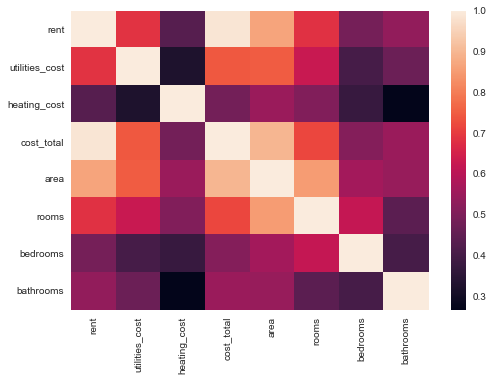

In [6]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from validation_metric import total_validation
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.model_selection import cross_val_score


#load data
df = pd.read_csv("C:/Users/test/Documents/GitHub/bachelorarbeit/_climate_change_mitigation/data/processed/berlin_preprocessed_test.csv")


_=sns.heatmap(df.iloc[:,1:9].corr())
plt.show()

# Drop 'cost_total' due to high correlation -> colliniarity?
df = df.drop('cost_total', axis=1)

# split data
X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = StandardScaler().fit_transform(X_train)
X_train = MinMaxScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = MinMaxScaler().fit_transform(X_test)

                 value
MAE              25.51
MAPE (%)         21.35
MSE            1196.49
RMSE (Units)     34.59
r-squared (%)    25.12


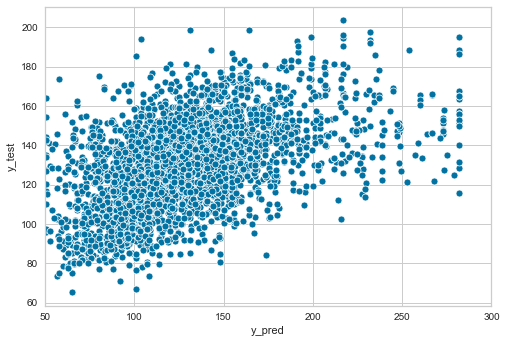

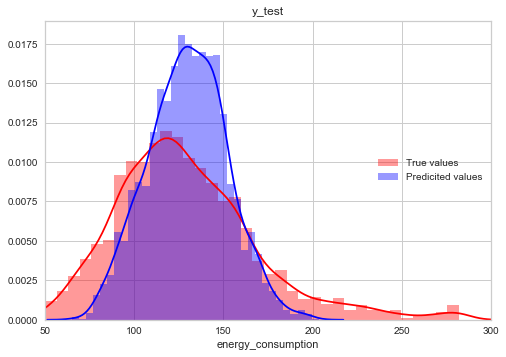

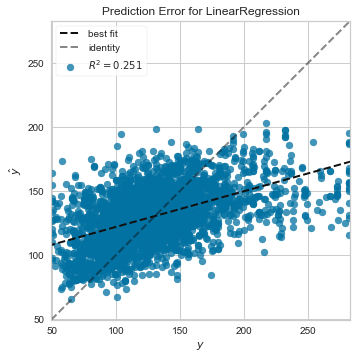

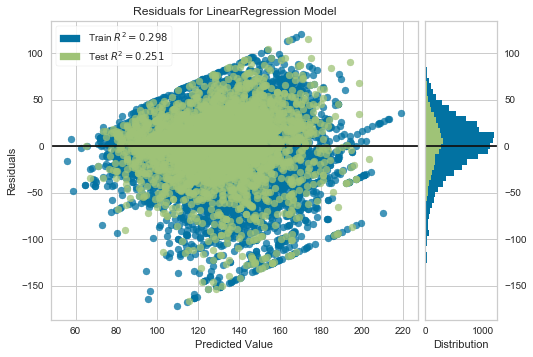

In [3]:
# LinReg:

from sklearn.linear_model import LinearRegression


steps = [('LinReg', LinearRegression())]

pipeline = Pipeline(steps)

LinReg_scaled = pipeline.fit(X_train, y_train)
y_pred = LinReg_scaled.predict(X_test)

metric_LinReg = total_validation(y_test, y_pred)

print(metric_LinReg)


_ = sns.scatterplot(y_test, y_pred)
_ = plt.xlim(50, 300)
_ = plt.ylabel('y_test')
_ = plt.xlabel('y_pred')
plt.show()

_ = sns.distplot(y_test, color = 'red', label = 'True values') 
_ = sns.distplot(y_pred, color = 'blue', label = 'Predicited values')
_ = plt.title('y_test')
_ = plt.legend(loc = 7)
_ = plt.xlim(50, 300)
plt.show()

visualizer = PredictionError(pipeline)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

visualizer = ResidualsPlot(pipeline)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show() 

{'alpha': 0.1, 'l1_ratio': 0.75, 'max_iter': 1000, 'tol': 1e-05}
-1385.242965411073
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=False, l1_ratio=0.75,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=1e-05, warm_start=False)
                 value
MAE              28.06
MAPE (%)         23.50
MSE            1387.86
RMSE (Units)     37.25
r-squared (%)    13.15


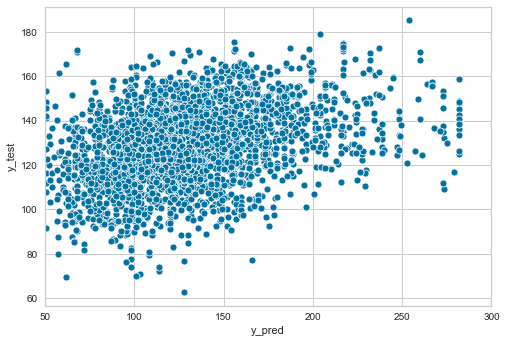

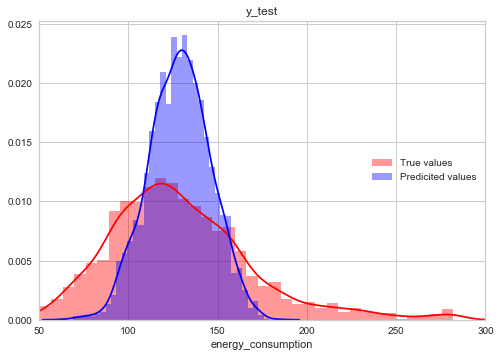

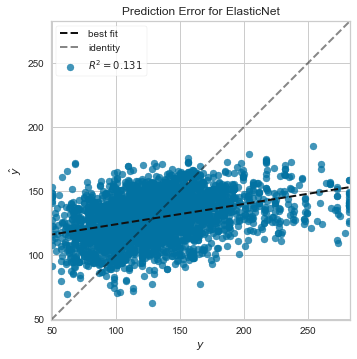

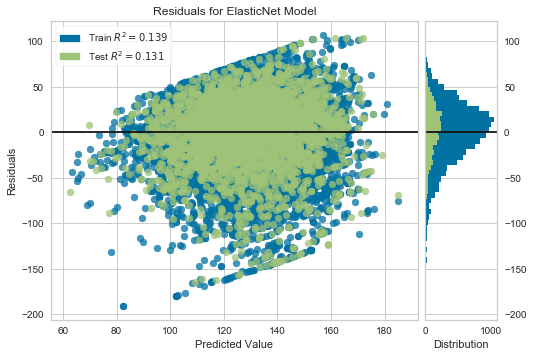

In [7]:
# ElasticNet:

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


ENReg = ElasticNet(fit_intercept = False, #weil daten schon centered
                  random_state = 42)

params_ENReg = {'alpha': [0.1,0.3,0.5,0.7],
                'tol': [0.00001, 0.05, 0.9, 1, 1.2],
            'l1_ratio': [0.25, 0.5, 0.75],
            'max_iter': [1000,2000]}

grid_ENReg = GridSearchCV(estimator = ENReg,
                      param_grid = params_ENReg,
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1)

grid_ENReg.fit(X_train, y_train)

print(grid_ENReg.best_params_)
print(grid_ENReg.best_score_)
print(grid_ENReg.best_estimator_)

y_pred_ENReg = grid_ENReg.best_estimator_.predict(X_test)


metric_ElasticNet = total_validation(y_test, y_pred_ENReg)

print(metric_ElasticNet)

_ = sns.scatterplot(y_test, y_pred_ENReg)
_ = plt.xlim(50, 300)
_ = plt.ylabel('y_test')
_ = plt.xlabel('y_pred')
plt.show()

_ = sns.distplot(y_test, color = 'red', label = 'True values')
_ = sns.distplot(y_pred_ENReg, color = 'blue', label = 'Predicited values')
_ = plt.title('y_test')
_ = plt.legend(loc = 7)
_ = plt.xlim(50, 300)
plt.show()

visualizer = PredictionError(grid_ENReg.best_estimator_)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

visualizer = ResidualsPlot(grid_ENReg.best_estimator_)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show() 

{'n_neighbors': 7, 'weights': 'distance'}
0.4651160593761725
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                    weights='distance')
                 value
MAE              28.06
MAPE (%)         23.50
MSE            1387.86
RMSE (Units)     37.25
r-squared (%)    13.15


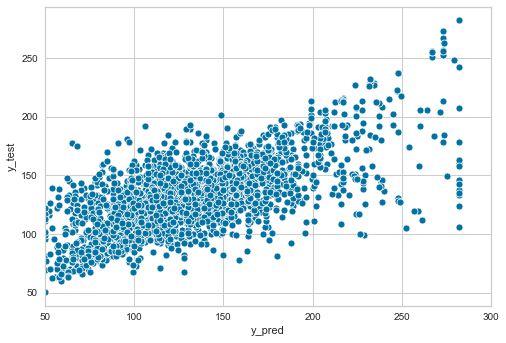

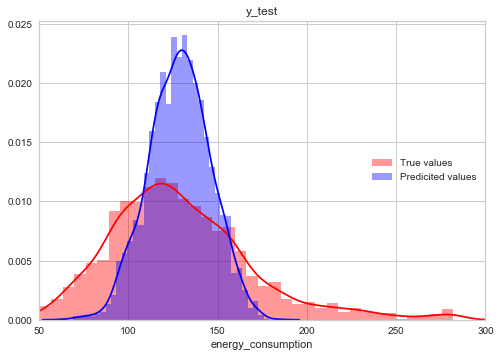

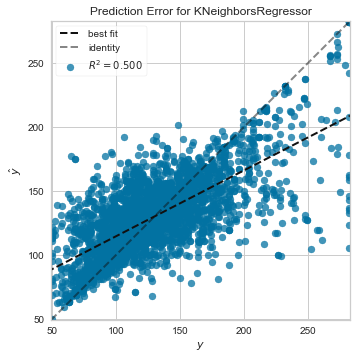

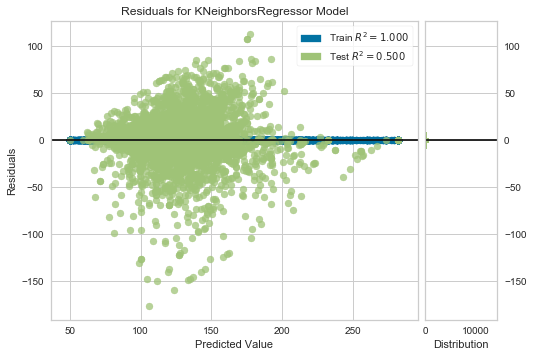

In [9]:
# K NeighborsReg:

from sklearn.neighbors import KNeighborsRegressor

KNReg = KNeighborsRegressor(n_jobs = -1)

params_KNReg = {'n_neighbors': [3,5,7,10],
                'weights': ['uniform', 'distance']}

grid_KNReg = GridSearchCV(estimator = KNReg,
                      param_grid = params_KNReg,
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1)

grid_KNReg.fit(X_train, y_train)

print(grid_KNReg.best_params_)
print(grid_KNReg.best_score_)
print(grid_KNReg.best_estimator_)

y_pred_KNReg = grid_KNReg.best_estimator_.predict(X_test)


metric_KNReg = total_validation(y_test, y_pred_ENReg)

print(metric_KNReg)

_ = sns.scatterplot(y_test, y_pred_KNReg)
_ = plt.xlim(50, 300)
_ = plt.ylabel('y_test')
_ = plt.xlabel('y_pred')
plt.show()

_ = sns.distplot(y_test, color = 'red', label = 'True values')
_ = sns.distplot(y_pred_ENReg, color = 'blue', label = 'Predicited values')
_ = plt.title('y_test')
_ = plt.legend(loc = 7)
_ = plt.xlim(50, 300)
plt.show()

visualizer = PredictionError(grid_KNReg.best_estimator_)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

visualizer = ResidualsPlot(grid_KNReg.best_estimator_)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show() 

{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 0.0011}
-1016.6597919526919
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.0011, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')
                 value
MAE              22.78
MAPE (%)         18.62
MSE            1054.71
RMSE (Units)     32.48
r-squared (%)    33.99


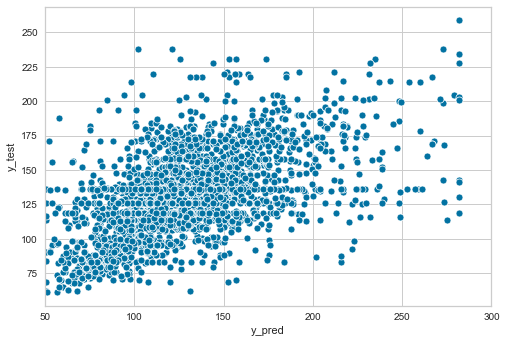

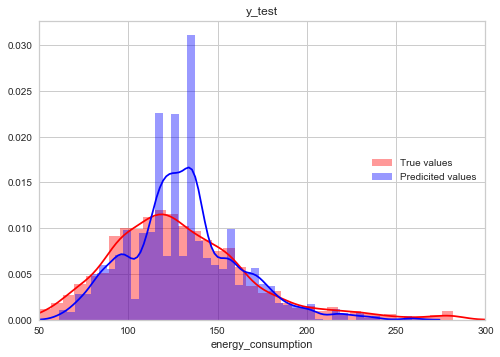

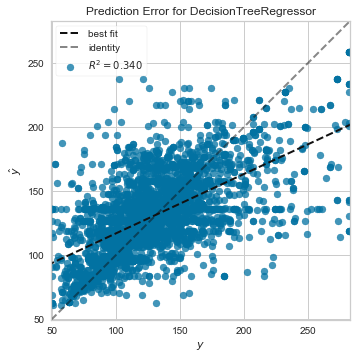

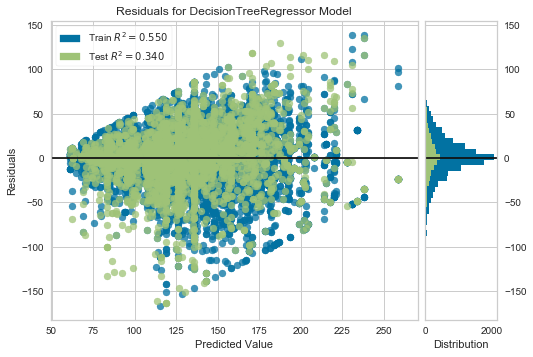

In [20]:
# DTReg:

from sklearn.tree import DecisionTreeRegressor

DTReg = DecisionTreeRegressor(random_state = 42)

params_DTReg = {'max_depth': [10, 15, 20, 50, 75],
                'min_samples_leaf': [0.001, 0.0011, 0.0012, 0.0013],
               'max_features': ['auto','sqrt','log2']}

grid_DTReg = GridSearchCV(estimator = DTReg,
                      param_grid = params_DTReg,
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1)

grid_DTReg.fit(X_train, y_train)

print(grid_DTReg.best_params_)
print(grid_DTReg.best_score_)
print(grid_DTReg.best_estimator_)

y_pred_DTReg = grid_DTReg.best_estimator_.predict(X_test)

metric_DTReg = total_validation(y_test, y_pred_DTReg)

print(metric_DTReg)

_ = sns.scatterplot(y_test, y_pred_DTReg)
_ = plt.xlim(50, 300)
_ = plt.ylabel('y_test')
_ = plt.xlabel('y_pred')
plt.show()

_ = sns.distplot(y_test, color = 'red', label = 'True values')
_ = sns.distplot(y_pred_DTReg, color = 'blue', label = 'Predicited values')
_ = plt.title('y_test')
_ = plt.legend(loc = 7)
_ = plt.xlim(50, 300)
plt.show()

visualizer = PredictionError(grid_DTReg.best_estimator_)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

visualizer = ResidualsPlot(grid_DTReg.best_estimator_)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show()  

In [ ]:
# SVMReg:

from sklearn.svm import SVR

SVReg = SVR()

params_SVReg = {'kernel': ['linear','poly', 'rbf'],
                'degree': [3,5,8],
               'gamma': ['scale','auto'],
               'tol':[0.0001, 0.001, 0.1, 1],
               'C':[1, 2, 3]}

grid_SVReg = GridSearchCV(estimator = SVReg,
                      param_grid = params_SVReg,
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1)

grid_SVReg.fit(X_train, y_train)

print(grid_SVReg.best_params_)
print(grid_SVReg.best_score_)
print(grid_SVReg.best_estimator_)

y_pred_SVReg = grid_SVReg.best_estimator_.predict(X_test)

print(metric_SVReg)

_ = sns.scatterplot(y_test, y_pred_SVReg)
_ = plt.xlim(50, 300)
_ = plt.ylabel('y_test')
_ = plt.xlabel('y_pred')
plt.show()

_ = sns.distplot(y_test, color = 'red', label = 'True values')
_ = sns.distplot(y_pred_SVReg, color = 'blue', label = 'Predicited values')
_ = plt.title('y_test')
_ = plt.legend(loc = 7)
_ = plt.xlim(50, 300)
plt.show()

visualizer = PredictionError(grid_SVReg.best_estimator_)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

visualizer = ResidualsPlot(grid_SVReg.best_estimator_)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show() 

C:\Users\test\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# Stacker:

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

estimators = [
    ('LinReg', LinearRegression()),
    ('ElasticNet', grid_ENReg.best_estimator_),
    ('KNReg', grid_KNReg.best_estimator_),
    ('DTReg', grid_DTReg.best_estimator_),
    ('SVMReg', grid_SVReg.best_estimator_)
]

stacker = StackingRegressor(estimators = estimators,
                            final_estimator = RandomForestRegressor(random_state=42)))

stacker_fitted = stacker.fit(X_train, y_train)
y_pred_stacker = stacker_fitted.predict(X_test)

metric_Stacker = total_validation(y_test, y_pred)

print(metric_Stacker)

_ = sns.scatterplot(y_test, y_pred_stacker)
_ = plt.xlim(50, 300)
_ = plt.ylabel('y_test')
_ = plt.xlabel('y_pred')
plt.show()

_ = sns.distplot(y_test, color = 'red', label = 'True values')
_ = sns.distplot(y_pred_stacker, color = 'blue', label = 'Predicited values')
_ = plt.title('y_test')
_ = plt.legend(loc = 7)
_ = plt.xlim(50, 300)
plt.show()

visualizer = PredictionError(stacker)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

visualizer = ResidualsPlot(stacker)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show() 

In [ ]:
metric_all = pd.concat([metric_LinReg, metric_ElasticNet, metric_KNReg, metric_DTReg, metric_SVMReg,metric_Stacker], axis=1)
metric_all.columns = ['LinReg','ElasticNet','KNReg','DTReg','SVMReg','Stacker']

print(metric_all)

In [ ]:
# RandomForestReg:

from sklearn.ensemble import RandomForestRegressor

steps = [
    ('scaler', StandardScaler()),
    ('normalizer', MinMaxScaler()),
    ('RFReg', RandomForestRegressor(random_state=42))]

pipeline = Pipeline(steps)

RFReg_scaled = pipeline.fit(X_train, y_train)
y_pred = RFReg_scaled.predict(X_test)

metric_RFReg = total_validation(y_test, y_pred)

print(metric_RFReg)

_ = sns.scatterplot(y_test, y_pred)
_ = plt.xlim(50, 300)
_ = plt.ylabel('y_test')
_ = plt.xlabel('y_pred')
plt.show()

_ = sns.distplot(y_test, color = 'red', label = 'True values')
_ = sns.distplot(y_pred, color = 'blue', label = 'Predicited values')
_ = plt.title('y_test')
_ = plt.legend(loc = 7)
_ = plt.xlim(50, 300)
plt.show()

visualizer = PredictionError(pipeline)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

visualizer = ResidualsPlot(pipeline)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show() 

In [ ]:
df.iloc[:,82:100].describe()

In [ ]:
y_pred